In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import torchtext
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import random
import pandas as pd

debug = False

print("Pytorch: \t\t", torch.__version__)
if not debug and torch.cuda.is_available():
    device='cuda'
    print('GPU:         \t\t', torch.cuda.get_device_name(0))
    print('Memory Usage:\t',
        round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB / ',
        round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
    torch.backends.cudnn.benchmark = True
else:
    print("GPU is **not available**")
    device='cpu'

Pytorch: 		 1.13.0+cu116
GPU:         		 NVIDIA GeForce GTX 1660 Ti
Memory Usage:	 0.0 GB /  0.0 GB


In [3]:
data_dir = pathlib.Path('/home/addy/datasets/aclImdb_v1/')

if data_dir.exists():
    print("Found the 'aclImdb_v1' dataset.")
else:
    print("Downloading the 'aclImdb_v1' dataset.")
    dataset_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    !wget {dataset_url} -P {data_dir.parent}
    !mkdir {data_dir}
    !tar xf {data_dir.parent / "aclImdb_v1.tar.gz"} -C {data_dir}
    !mv {data_dir / 'train' / 'unsup'} {data_dir / 'unsup'}
data_dir = data_dir / 'aclImdb'


Found the 'aclImdb_v1' dataset.


In [4]:
def cleanup(data):
    return data.replace('<br />', '')

class ArrayDataset(torch.utils.data.Dataset):
    def __init__(self, array):
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        res = self.array[index]
        return cleanup(open(res[1]).read()), res[2]
    
    def indices(self):
        return self.array[:,0]

    def split(self, p=0.5):
        count = len(self.array)
        index = np.arange(count)
        first = int(count * p)
        return [
            ArrayDataset(self.array[index[:first]]), 
            ArrayDataset(self.array[index[first:]])
        ]

    def pop(self, indices):
        fltr = np.isin(self.array[:, 0], indices)
        # print(fltr)
        removed = ArrayDataset(self.array[fltr])
        self.array = self.array[~fltr]
        return removed

    def addLabels(self, labels):
        self.array = np.hstack([self.array, np.expand_dims(labels, axis=1)])
        return self

    def addData(self, otherArrayDataset):
        self.array = np.append(self.array, otherArrayDataset.array, axis=0)


class UnlabelledDataset(ArrayDataset):    
    def __getitem__(self, index):
        res = self.array[index]
        return cleanup(open(res[1]).read()), res[0]



class OracleDataset():
    def __init__(self, array):
        self.array = array
    def query(self, indices):
        return self.array[np.isin(self.array[:, 0], indices),1]


def init():
    test_dir = data_dir / 'test'
    train_dir = data_dir / 'train'
    files = [y for y in (train_dir).glob('*/*')] 
    data = np.array([(id, i.parent.stem, i) for id, i in enumerate(files)])
    # print(all_data)
    oracle_data = data[:,[0, 1]]
    unlabelled_data = data[:,[0, 2]]
    oracle_dataset = OracleDataset(oracle_data)
    unlabelled_dataset = UnlabelledDataset(unlabelled_data)
    return unlabelled_dataset, oracle_dataset

def random_query(dataset, count, model=None, device=None):
    return np.random.choice(dataset.indices(), count)

def binary_least_confidence_query(dataset, query_size, model, device, deterministic=True):
    confidences = []
    indices = []

    vocab = model['vocab']
    text_pipeline = lambda x: vocab(tokenizer(x))
    label_pipeline = lambda x: 1 if x == 'pos' else 0
    

    ul_dataloader = DataLoader(
        dataset, 
        num_workers=8,
        batch_size=batch_size, 
        collate_fn=partial(collate_unlabelled_batch, text_pipeline))
    
    with torch.no_grad():
        for X, idx in tqdm(ul_dataloader):
            X = X.to(device)
            probabilities = model['model'](X)
            confidence = (torch.abs(probabilities - 0.5)*2).squeeze(dim=-1)
            
            confidences.extend(confidence.cpu().tolist())
            indices.extend(idx)
            
    conf = np.asarray(confidences)
    ind = np.asarray(indices)
    sorted_pool = np.argsort(conf)
    # Return the indices corresponding to the lowest `query_size` confidences
    return ind[sorted_pool][0:query_size]

In [5]:
from collections import Counter, OrderedDict
from torchtext.data.utils import get_tokenizer
from torch import nn
from functools import partial

tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


def build_vocab_from_iterator(iterator, min_freq: int = 1, specials = [], special_first: bool = True, vocab_size = None):
    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    if specials is not None:
        for tok in specials:
            del counter[tok]

    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[0])
    sorted_by_freq_tuples.sort(key=lambda x: x[1], reverse=True)
    
    if vocab_size is not None:
        sorted_by_freq_tuples = sorted_by_freq_tuples[:vocab_size]

    ordered_dict = OrderedDict(sorted_by_freq_tuples)

    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)

    word_vocab = torchtext.vocab.vocab(ordered_dict, min_freq=min_freq)
    return word_vocab


def collate_unlabelled_batch(text_pipeline, batch):
     indices_list, text_list = [], []
     for (text, index) in batch:
          input = text_pipeline(text)
          indices_list.append(index)
          
          a = torch.tensor(input[:sequence_max_length], dtype=torch.int64)
          b = torch.zeros(max(0, sequence_max_length - len(input)), dtype=torch.int64)
          text_list.append(torch.cat((a,b)))
               
     text_list = torch.stack(text_list)
     return text_list, indices_list
    

def collate_batch(text_pipeline, label_pipeline, batch):
     label_list, text_list = [], []
     for (text, label) in batch:
          input = text_pipeline(text)
          label_list.append(torch.tensor([label_pipeline(label)], dtype=torch.float32))
          
          a = torch.tensor(input[:sequence_max_length], dtype=torch.int64)
          b = torch.zeros(max(0, sequence_max_length - len(input)), dtype=torch.int64)
          text_list.append(torch.cat((a,b)))
               
     label_list = torch.stack(label_list)
     text_list = torch.stack(text_list)
     return text_list, label_list

class ClassifyNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        # self.pool = nn.AvgPool1d(3, stride=2)
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.emb(x)
        # print(x.shape)
        x = self.dropout(x)
        x = torch.mean(x, 1)
        x = self.dropout2(x)
        # print(x.shape)
        x = self.fc(x)

        return torch.sigmoid(x)

def train_loop(dataloader, model, loss_fn, optimizer, history=None):
    size = len(dataloader.dataset)
    total_loss, accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        #FORWARD PASS
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    accuracy /= size
    total_loss /= size
    if history is not None:
        history['train_loss'].append(total_loss)
        history['train_accuracy'].append(accuracy)
    return loss, accuracy


def test_loop(dataloader, model, loss_fn, history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            accuracy += (torch.round(pred) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy /= size

    history['test_loss'].append(loss)
    history['test_accuracy'].append(accuracy)
    return loss, accuracy


def train_model(train_dataset, test_dataset,epochs=40):
    history = {
        'train_loss':[],
        'train_accuracy':[],
        'test_loss':[],
        'test_accuracy':[]
    }
    vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<pad>", "<unk>"], vocab_size=10000-2)
    vocab.set_default_index(vocab["<unk>"])
    text_pipeline = lambda x: vocab(tokenizer(x))
    label_pipeline = lambda x: 1 if x == 'pos' else 0

    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        num_workers=8,
        batch_size=batch_size,
        collate_fn=partial(collate_batch, text_pipeline, label_pipeline))

    test_dataloader = DataLoader(
        test_dataset, 
        num_workers=8,
        batch_size=batch_size, 
        collate_fn=partial(collate_batch, text_pipeline, label_pipeline))

    vocab_size = len(vocab)

    model = ClassifyNet(vocab_size, emsize, num_classes).to(device)
        
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

    for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
        train_loop(train_dataloader, model, loss_fn, optimizer, history)
        test_loop(test_dataloader, model, loss_fn, history)

    
    return {
        "model": model,
        "vocab": vocab,
        
    }, history

In [6]:

# Initializing parameters
batch_size = 32     # Reduce this if you get memory errors
seed = 2476          # A random seed to get replicable results
sequence_max_length = 250
vocab_size = 10000
epochs = 30

emsize = 16
num_classes = 1


In [7]:
K = 2000 # Total budget for labelling
p = int(K * .4) # Number of examples to begin with
n = 3
ks = [(K-p)//n]*n
ks[0] += K - p - sum(ks) # removes rounding errors

In [8]:
history = []

unlabelled_dataset, oracle = init()
print(f"Starting with unlabelled_dataset of size {len(unlabelled_dataset)}")

vocab = build_vocab_from_iterator(yield_tokens(unlabelled_dataset), specials=["<pad>", "<unk>"], vocab_size=10000-2)
vocab.set_default_index(vocab["<unk>"])
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == 'pos' else 0


chosen_indices = random_query(unlabelled_dataset, p)

train_dataset, test_dataset =  unlabelled_dataset.pop(chosen_indices)\
                                    .addLabels(oracle.query(chosen_indices))\
                                    .split(p=0.5)
print(f"Starting with randomly sampled train_dataset of size {len(train_dataset)} and test_dataset of size {len(test_dataset)}")

print(f"Training new model ...")
model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
history.append(stats)

for k in ks:
    print(f"Quering {k} items from the from  ...")
    chosen_indices = random_query(unlabelled_dataset, k)

    newData = unlabelled_dataset.pop(chosen_indices)\
                          .addLabels(oracle.query(chosen_indices))
    train_dataset.addData(newData)
    print(f"New train_dataset size: {len(train_dataset)}.")
    print(f"Training new model ...")
    
    model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
    history.append(stats)
    


#~ 1 minute per training


Starting with unlabelled_dataset of size 25000
Starting with randomly sampled train_dataset of size 393 and test_dataset of size 393
Training new model ...


00:29 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.02epoch/s]


Quering 400 items from the from  ...
New train_dataset size: 792.
Training new model ...


00:31 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.04s/epoch]


Quering 400 items from the from  ...
New train_dataset size: 1190.
Training new model ...


00:32 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.07s/epoch]


Quering 400 items from the from  ...
New train_dataset size: 1585.
Training new model ...


00:33 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.11s/epoch]


Text(0.5, 1.0, 'Test Accuracy')

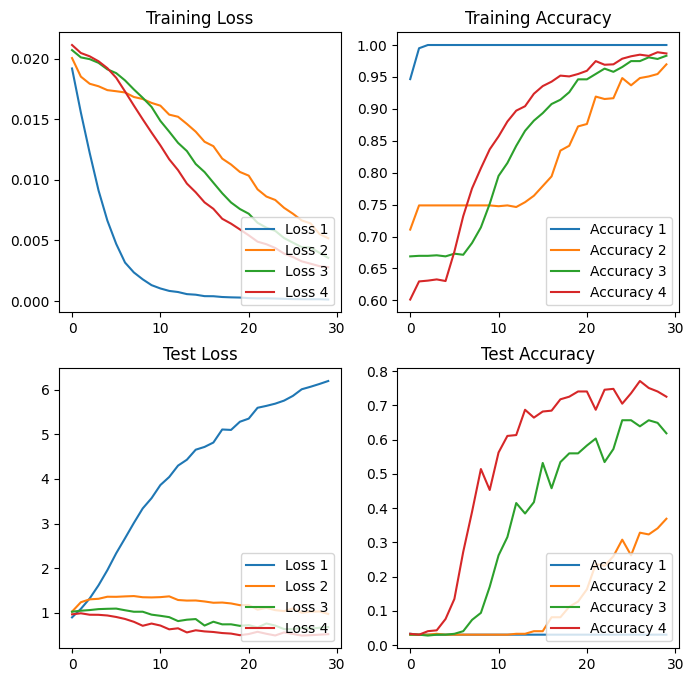

In [9]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
for id, i in enumerate(history):
    plt.plot(i['train_loss'], label=f'Loss {id+1}')
plt.legend(loc='lower right')
plt.title('Training Loss')

plt.subplot(2, 2, 2)
for id, i in enumerate(history):
    plt.plot(i['train_accuracy'], label=f'Accuracy {id+1}')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 3)
for id, i in enumerate(history):
    plt.plot(i['test_loss'], label=f'Loss {id+1}')
plt.legend(loc='lower right')
plt.title('Test Loss')

plt.subplot(2, 2, 4)
for id, i in enumerate(history):
    plt.plot(i['test_accuracy'], label=f'Accuracy {id+1}')
plt.legend(loc='lower right')
plt.title('Test Accuracy')


In [10]:
history = []

unlabelled_dataset, oracle = init()
print(f"Starting with unlabelled_dataset of size {len(unlabelled_dataset)}")

chosen_indices = random_query(unlabelled_dataset, p)

train_dataset, test_dataset =  unlabelled_dataset.pop(chosen_indices)\
                                    .addLabels(oracle.query(chosen_indices))\
                                    .split(p=0.5)
print(f"Starting with randomly sampled train_dataset of size {len(train_dataset)} and test_dataset of size {len(test_dataset)}")

print(f"Training new model ...")
model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
history.append(stats)

for k in ks:
    print(f"Quering {k} items from the from  ...")
    chosen_indices = binary_least_confidence_query(unlabelled_dataset, k, model=model, device=device)

    newData = unlabelled_dataset.pop(chosen_indices)\
                          .addLabels(oracle.query(chosen_indices))
    train_dataset.addData(newData)
    print(f"New train_dataset size: {len(train_dataset)}.")
    print(f"Training new model ...")
    
    model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
    history.append(stats)
    


#~ 1 minute per training


Starting with unlabelled_dataset of size 25000
Starting with randomly sampled train_dataset of size 395 and test_dataset of size 396
Training new model ...


00:26 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.12epoch/s]


Quering 400 items from the from  ...


100%|██████████| 757/757 [00:01<00:00, 441.40it/s]


New train_dataset size: 795.
Training new model ...


00:27 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.09epoch/s]


Quering 400 items from the from  ...


100%|██████████| 745/745 [00:01<00:00, 439.47it/s]


New train_dataset size: 1195.
Training new model ...


00:29 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.02epoch/s]


Quering 400 items from the from  ...


100%|██████████| 732/732 [00:01<00:00, 412.32it/s]


New train_dataset size: 1595.
Training new model ...


00:31 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.05s/epoch]


Text(0.5, 1.0, 'Test Accuracy')

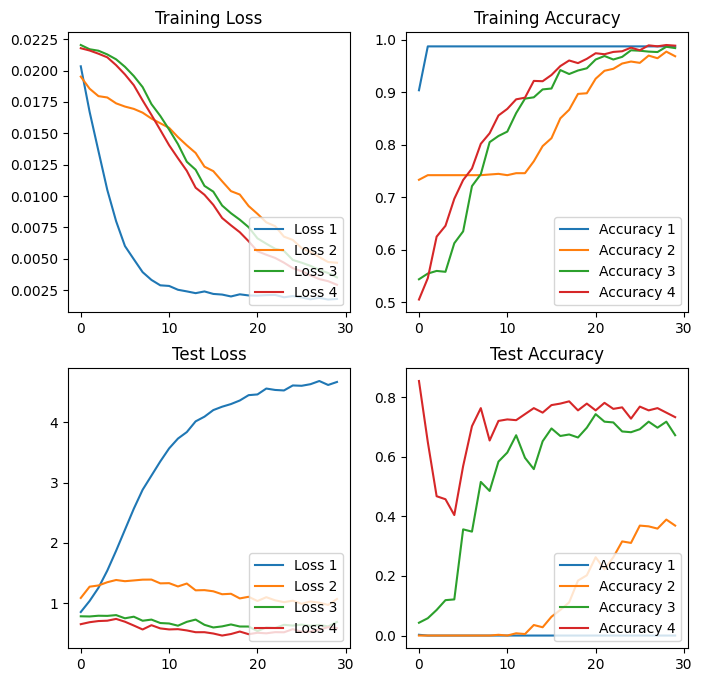

In [11]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
for id, i in enumerate(history):
    plt.plot(i['train_loss'], label=f'Loss {id+1}')
plt.legend(loc='lower right')
plt.title('Training Loss')

plt.subplot(2, 2, 2)
for id, i in enumerate(history):
    plt.plot(i['train_accuracy'], label=f'Accuracy {id+1}')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 3)
for id, i in enumerate(history):
    plt.plot(i['test_loss'], label=f'Loss {id+1}')
plt.legend(loc='lower right')
plt.title('Test Loss')

plt.subplot(2, 2, 4)
for id, i in enumerate(history):
    plt.plot(i['test_accuracy'], label=f'Accuracy {id+1}')
plt.legend(loc='lower right')
plt.title('Test Accuracy')


In [12]:
def variance(t):
    return torch.var(t, axis=1)

In [13]:
def klDivergence(t):
    return torch.sum((t * torch.log(t/torch.mean(t, axis=1).unsqueeze(-1))), axis=1)

In [14]:
def entropy(t):
    return torch.sum(t * torch.log(t), axis=1)

In [15]:
# def binary_model_training_disagreement(unlabelled_dataset, k, train_dataset, disagreement=entropy, model=None, device=device):
#     history = {}
#     vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<pad>", "<unk>"], vocab_size=10000-2)
#     vocab.set_default_index(vocab["<unk>"])
#     text_pipeline = lambda x: vocab(tokenizer(x))
#     label_pipeline = lambda x: 1 if x == 'pos' else 0

#     train_dataloader = DataLoader(
#         train_dataset,
#         shuffle=True,
#         num_workers=8,
#         batch_size=batch_size,
#         collate_fn=partial(collate_batch, text_pipeline, label_pipeline))

#     ul_dataloader = DataLoader(
#         unlabelled_dataset, 
#         num_workers=8,
#         shuffle=False,
#         batch_size=batch_size, 
#         collate_fn=partial(collate_unlabelled_batch, text_pipeline))

#     vocab_size = len(vocab)

#     model = ClassifyNet(vocab_size, emsize, num_classes).to(device)
        
#     loss_fn = nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

#     for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
#         train_loop(train_dataloader, model, loss_fn, optimizer)
#         with torch.no_grad():

#             for X, indices in ul_dataloader:
#                 X = X.to(device)
#                 probabilities = model(X)
#                 for i, index in enumerate(indices):
#                     if index not in history:
#                         history[index]=a=[]
#                     else:
#                         a = history[index]
#                     a.append(probabilities[i])
#     ind = torch.tensor(list(history.keys()))
#     history = torch.tensor(list(history.values()))
#     sorted_pool = torch.argsort(disagreement(history), descending=True)
#     return ind[sorted_pool[:k]]




# history = []

# K = 2000 # Total budget for labelling
# p = int(K * .4) # Number of examples to begin with
# n = 3
# ks = [(K-p)//n]*n
# ks[0] += K - p - sum(ks) # removes rounding errors

# unlabelled_dataset, oracle = init()
# print(f"Starting with unlabelled_dataset of size {len(unlabelled_dataset)}")

# chosen_indices = random_query(unlabelled_dataset, p)

# train_dataset, test_dataset =  unlabelled_dataset.pop(chosen_indices)\
#                                     .addLabels(oracle.query(chosen_indices))\
#                                     .split(p=0.5)
# print(f"Starting with randomly sampled train_dataset of size {len(train_dataset)} and test_dataset of size {len(test_dataset)}")

# print(f"Training new model ...")
# model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
# history.append(stats)

# for k in ks:
#     print(f"Quering {k} items from the from  ...")
#     chosen_indices = binary_model_training_disagreement(unlabelled_dataset, k, device=device, train_dataset=train_dataset)

#     newData = unlabelled_dataset.pop(chosen_indices)\
#                           .addLabels(oracle.query(chosen_indices))
#     train_dataset.addData(newData)
#     print(f"New train_dataset size: {len(train_dataset)}.")
#     print(f"Training new model ...")
    
#     model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
#     history.append(stats)
    


# #~ 1 minute per training


In [16]:

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 2, 1)
# for id, i in enumerate(history):
#     plt.plot(i['train_loss'], label=f'Loss {id+1}')
# plt.legend(loc='lower right')
# plt.title('Training Loss')

# plt.subplot(2, 2, 2)
# for id, i in enumerate(history):
#     plt.plot(i['train_accuracy'], label=f'Accuracy {id+1}')
# plt.legend(loc='lower right')
# plt.title('Training Accuracy')

# plt.subplot(2, 2, 3)
# for id, i in enumerate(history):
#     plt.plot(i['test_loss'], label=f'Loss {id+1}')
# plt.legend(loc='lower right')
# plt.title('Test Loss')

# plt.subplot(2, 2, 4)
# for id, i in enumerate(history):
#     plt.plot(i['test_accuracy'], label=f'Accuracy {id+1}')
# plt.legend(loc='lower right')
# plt.title('Test Accuracy')


In [17]:
# !pip install baal

In [18]:
from baal.bayesian.dropout import MCDropoutModule

In [19]:
def binary_disagreement_bald(unlabelled_dataset, k, model, disagreement=entropy, device=device, iterations=20):
    entropies = []
    indices = []

    vocab = model['vocab']
    model = model['model']
    text_pipeline = lambda x: vocab(tokenizer(x))
    label_pipeline = lambda x: 1 if x == 'pos' else 0
    
    ul_dataloader = DataLoader(
        unlabelled_dataset, 
        num_workers=8,
        shuffle=False,
        batch_size=batch_size, 
        collate_fn=partial(collate_unlabelled_batch, text_pipeline))

    with MCDropoutModule(model) as mcdropout_model:
        with torch.no_grad():
            for X, ind in ul_dataloader:
                X = X.to(device)
                conf = torch.stack([mcdropout_model(X).squeeze() for _ in range(iterations)])
                entropies.extend(entropy(conf.T).cpu())
                indices.extend(ind)

    entropies = torch.stack(entropies)
    indices = torch.tensor(indices)
    sorted_pool = torch.argsort(entropies, descending=True)
    return indices[sorted_pool[k:]]


history = []

unlabelled_dataset, oracle = init()
print(f"Starting with unlabelled_dataset of size {len(unlabelled_dataset)}")

chosen_indices = random_query(unlabelled_dataset, p)

train_dataset, test_dataset =  unlabelled_dataset.pop(chosen_indices)\
                                    .addLabels(oracle.query(chosen_indices))\
                                    .split(p=0.5)
print(f"Starting with randomly sampled train_dataset of size {len(train_dataset)} and test_dataset of size {len(test_dataset)}")

print(f"Training new model ...")
model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
history.append(stats)

for k in ks:
    print(f"Quering {k} items from the from  ...")
    chosen_indices = binary_disagreement_bald(unlabelled_dataset, k, model)

    newData = unlabelled_dataset.pop(chosen_indices)\
                          .addLabels(oracle.query(chosen_indices))
    train_dataset.addData(newData)
    print(f"New train_dataset size: {len(train_dataset)}.")
    print(f"Training new model ...")
    
    model, stats = train_model(train_dataset, test_dataset, epochs=epochs)
    history.append(stats)


Starting with unlabelled_dataset of size 25000
Starting with randomly sampled train_dataset of size 395 and test_dataset of size 395
Training new model ...


00:29 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  1.02epoch/s]

Quering 400 items from the from  ...


New train_dataset size: 24205.
Training new model ...


01:35 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  3.19s/epoch]

Quering 400 items from the from  ...


New train_dataset size: 24205.
Training new model ...


01:33 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  3.12s/epoch]

Quering 400 items from the from  ...


New train_dataset size: 24205.
Training new model ...


01:32 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  3.08s/epoch]


Text(0.5, 1.0, 'Test Accuracy')

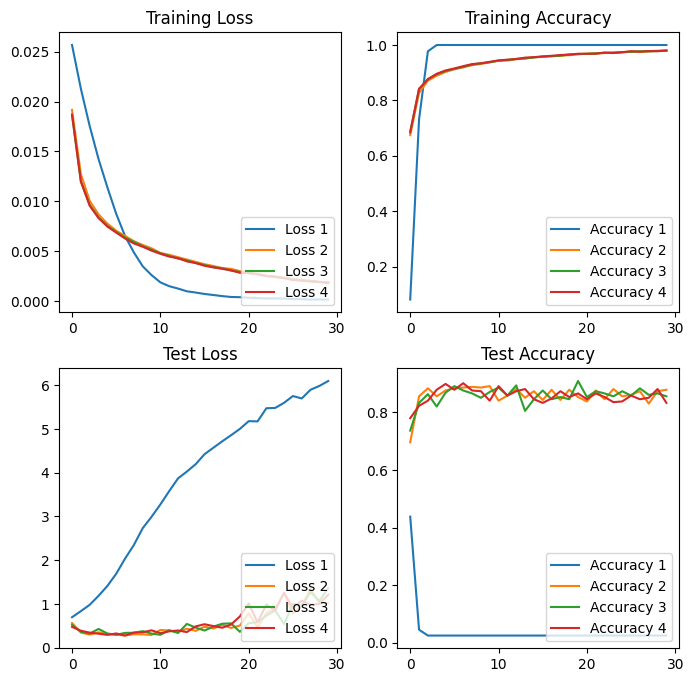

In [20]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
for id, i in enumerate(history):
    plt.plot(i['train_loss'], label=f'Loss {id+1}')
plt.legend(loc='lower right')
plt.title('Training Loss')

plt.subplot(2, 2, 2)
for id, i in enumerate(history):
    plt.plot(i['train_accuracy'], label=f'Accuracy {id+1}')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 3)
for id, i in enumerate(history):
    plt.plot(i['test_loss'], label=f'Loss {id+1}')
plt.legend(loc='lower right')
plt.title('Test Loss')

plt.subplot(2, 2, 4)
for id, i in enumerate(history):
    plt.plot(i['test_accuracy'], label=f'Accuracy {id+1}')
plt.legend(loc='lower right')
plt.title('Test Accuracy')
